# Part g: Bias-variance trade-off and resampling techniques

In [96]:
# Import libraries and functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Import our own implementations
import importlib, OLS, prepare_data, polynomial_features
importlib.reload(OLS)
importlib.reload(prepare_data)
importlib.reload(polynomial_features)

from prepare_data import prepare_data
from polynomial_features import polynomial_features
from OLS import OLS_parameters

# Styling function
from Set_latex_params import set_mpl_latex_style
set_mpl_latex_style()



In [97]:
# Set random seed for reproducibility
np.random.seed(6114)

# Prepare data
x, y, x_train, x_test, y_train, y_test, y_noisy = prepare_data(n=100)

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")


Training samples: 80
Test samples: 20


Computing training and test MSE for different polynomial degrees...


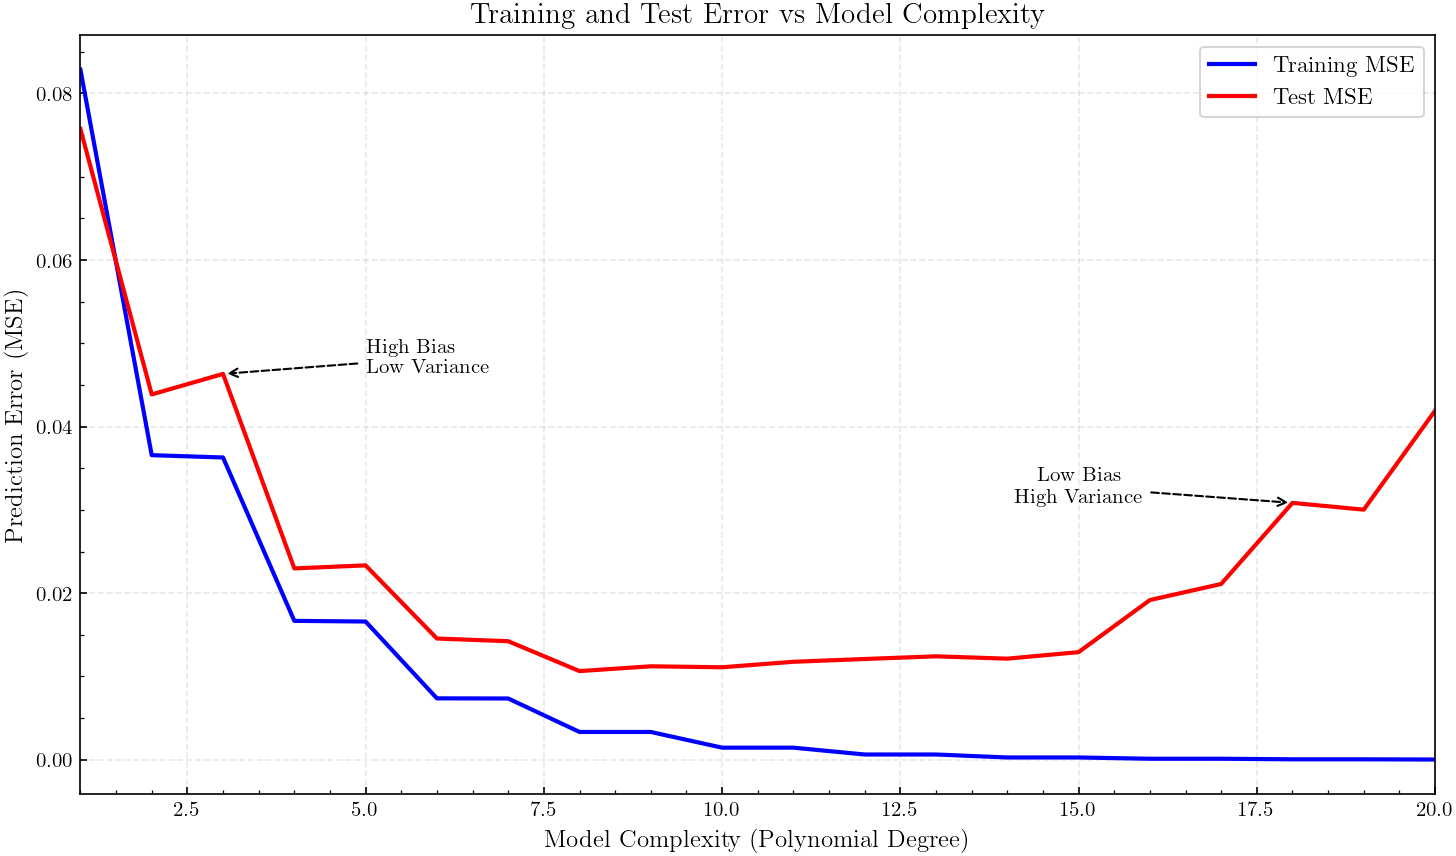

Minimum test MSE occurs at degree 8
Minimum test MSE value: 0.010641


In [98]:
# (2) Create figure similar to Fig 2.11 of Hastie, Tibshirani, and Friedman
# This shows training and test MSE vs model complexity

max_degree = 20
n_bootstrap = 100

# Initialize arrays
degrees = np.arange(1, max_degree + 1)
mse_train = np.zeros(max_degree)
mse_test = np.zeros(max_degree)

print("Computing training and test MSE for different polynomial degrees...")

for degree in degrees:
    # Create polynomial features
    X_train_poly = polynomial_features(x_train, degree, intercept=False)
    X_test_poly = polynomial_features(x_test, degree, intercept=False)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)
    
    # Calculate y_offset
    y_offset = np.mean(y_train)
    
    # Train OLS model
    beta = OLS_parameters(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = X_train_scaled @ beta + y_offset
    y_pred_test = X_test_scaled @ beta + y_offset
    
    # Calculate MSE
    mse_train[degree-1] = mean_squared_error(y_train, y_pred_train)
    mse_test[degree-1] = mean_squared_error(y_test, y_pred_test)

# Plot similar to Fig 2.11
plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_train, 'b-', label='Training MSE', linewidth=2)
plt.plot(degrees, mse_test, 'r-', label='Test MSE', linewidth=2)
plt.xlabel('Model Complexity (Polynomial Degree)', fontsize=12)
plt.ylabel('Prediction Error (MSE)', fontsize=12)
plt.title('Training and Test Error vs Model Complexity', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(1, max_degree)
# plt.yscale('log')

# Add annotations for bias and variance regions
plt.annotate('High Bias\nLow Variance', xy=(3, mse_test[2]), xytext=(5, mse_test[2]*1),
            arrowprops=dict(arrowstyle='->', color='black', linestyle='--'),
            fontsize=10, ha='left')
plt.annotate('Low Bias\nHigh Variance', xy=(18, mse_test[17]), xytext=(15, mse_test[17]*1),
            arrowprops=dict(arrowstyle='->', color='black', linestyle='--'),
            fontsize=10, ha='center')

plt.tight_layout()
plt.savefig("Plots/mse_train_test_vs_degree_hastie_style.pdf", bbox_inches="tight")
plt.show()

print(f"Minimum test MSE occurs at degree {np.argmin(mse_test)+1}")
print(f"Minimum test MSE value: {np.min(mse_test):.6f}")


In [99]:
# (4) Bias-variance analysis using bootstrap resampling
print("\n" + "="*60)
print("BIAS-VARIANCE ANALYSIS WITH BOOTSTRAP")
print("="*60)

# Parameters
max_degree = 15
n_bootstrap = 100

# Initialize arrays
degrees = np.arange(1, max_degree + 1)
error = np.zeros(max_degree)
bias = np.zeros(max_degree)
variance = np.zeros(max_degree)

print(f"Analyzing polynomial degrees 1 to {max_degree}")
print(f"Using {n_bootstrap} bootstrap samples")

for degree in degrees:
    print(f"\nProcessing degree {degree}...")
    
    # Create polynomial features
    X_train_poly = polynomial_features(x_train, degree, intercept=False)
    X_test_poly = polynomial_features(x_test, degree, intercept=False)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)
    
    # Calculate y_offset
    y_offset = np.mean(y_train)
    
    # Bootstrap resampling - store predictions from each bootstrap sample
    y_pred = np.empty((len(y_test), n_bootstrap))
    
    for i in range(n_bootstrap):
        # Resample training data
        X_boot, y_boot = resample(X_train_scaled, y_train)
        
        # Train OLS model on bootstrap sample
        beta = OLS_parameters(X_boot, y_boot)
        
        # Make predictions on test set
        y_pred[:, i] = X_test_scaled @ beta + y_offset
    
    # Calculate error, bias, and variance - FIXED VERSION
    # Fix the array dimension issue by ensuring y_test is properly shaped
    y_test_reshaped = y_test.reshape(-1, 1)  # Make it a column vector
    
    # Calculate error: mean of squared differences
    error[degree-1] = np.mean(np.mean((y_test_reshaped - y_pred)**2, axis=1, keepdims=True))
    
    # Calculate bias: mean of (y_test - mean_prediction)^2
    mean_prediction = np.mean(y_pred, axis=1, keepdims=True)
    bias[degree-1] = np.mean((y_test_reshaped - mean_prediction)**2)
    
    # Calculate variance: mean of variance across bootstrap samples
    variance[degree-1] = np.mean(np.var(y_pred, axis=1, keepdims=True))
    
    print(f"  Error: {error[degree-1]:.6f}")
    print(f"  Bias²: {bias[degree-1]:.6f}")
    print(f"  Variance: {variance[degree-1]:.6f}")
    print(f"  Bias² + Variance: {bias[degree-1] + variance[degree-1]:.6f}")

print("\nBias-variance analysis completed!")



BIAS-VARIANCE ANALYSIS WITH BOOTSTRAP
Analyzing polynomial degrees 1 to 15
Using 100 bootstrap samples

Processing degree 1...
  Error: 0.075581
  Bias²: 0.075277
  Variance: 0.000304
  Bias² + Variance: 0.075581

Processing degree 2...
  Error: 0.052643
  Bias²: 0.046823
  Variance: 0.005820
  Bias² + Variance: 0.052643

Processing degree 3...
  Error: 0.056540
  Bias²: 0.047068
  Variance: 0.009472
  Bias² + Variance: 0.056540

Processing degree 4...
  Error: 0.032430
  Bias²: 0.019426
  Variance: 0.013004
  Bias² + Variance: 0.032430

Processing degree 5...
  Error: 0.044525
  Bias²: 0.017954
  Variance: 0.026571
  Bias² + Variance: 0.044525

Processing degree 6...
  Error: 0.156080
  Bias²: 0.045059
  Variance: 0.111020
  Bias² + Variance: 0.156080

Processing degree 7...
  Error: 0.456317
  Bias²: 0.089190
  Variance: 0.367127
  Bias² + Variance: 0.456317

Processing degree 8...
  Error: 0.384850
  Bias²: 0.020775
  Variance: 0.364076
  Bias² + Variance: 0.384850

Processing degr

<Figure size 1800x1200 with 0 Axes>

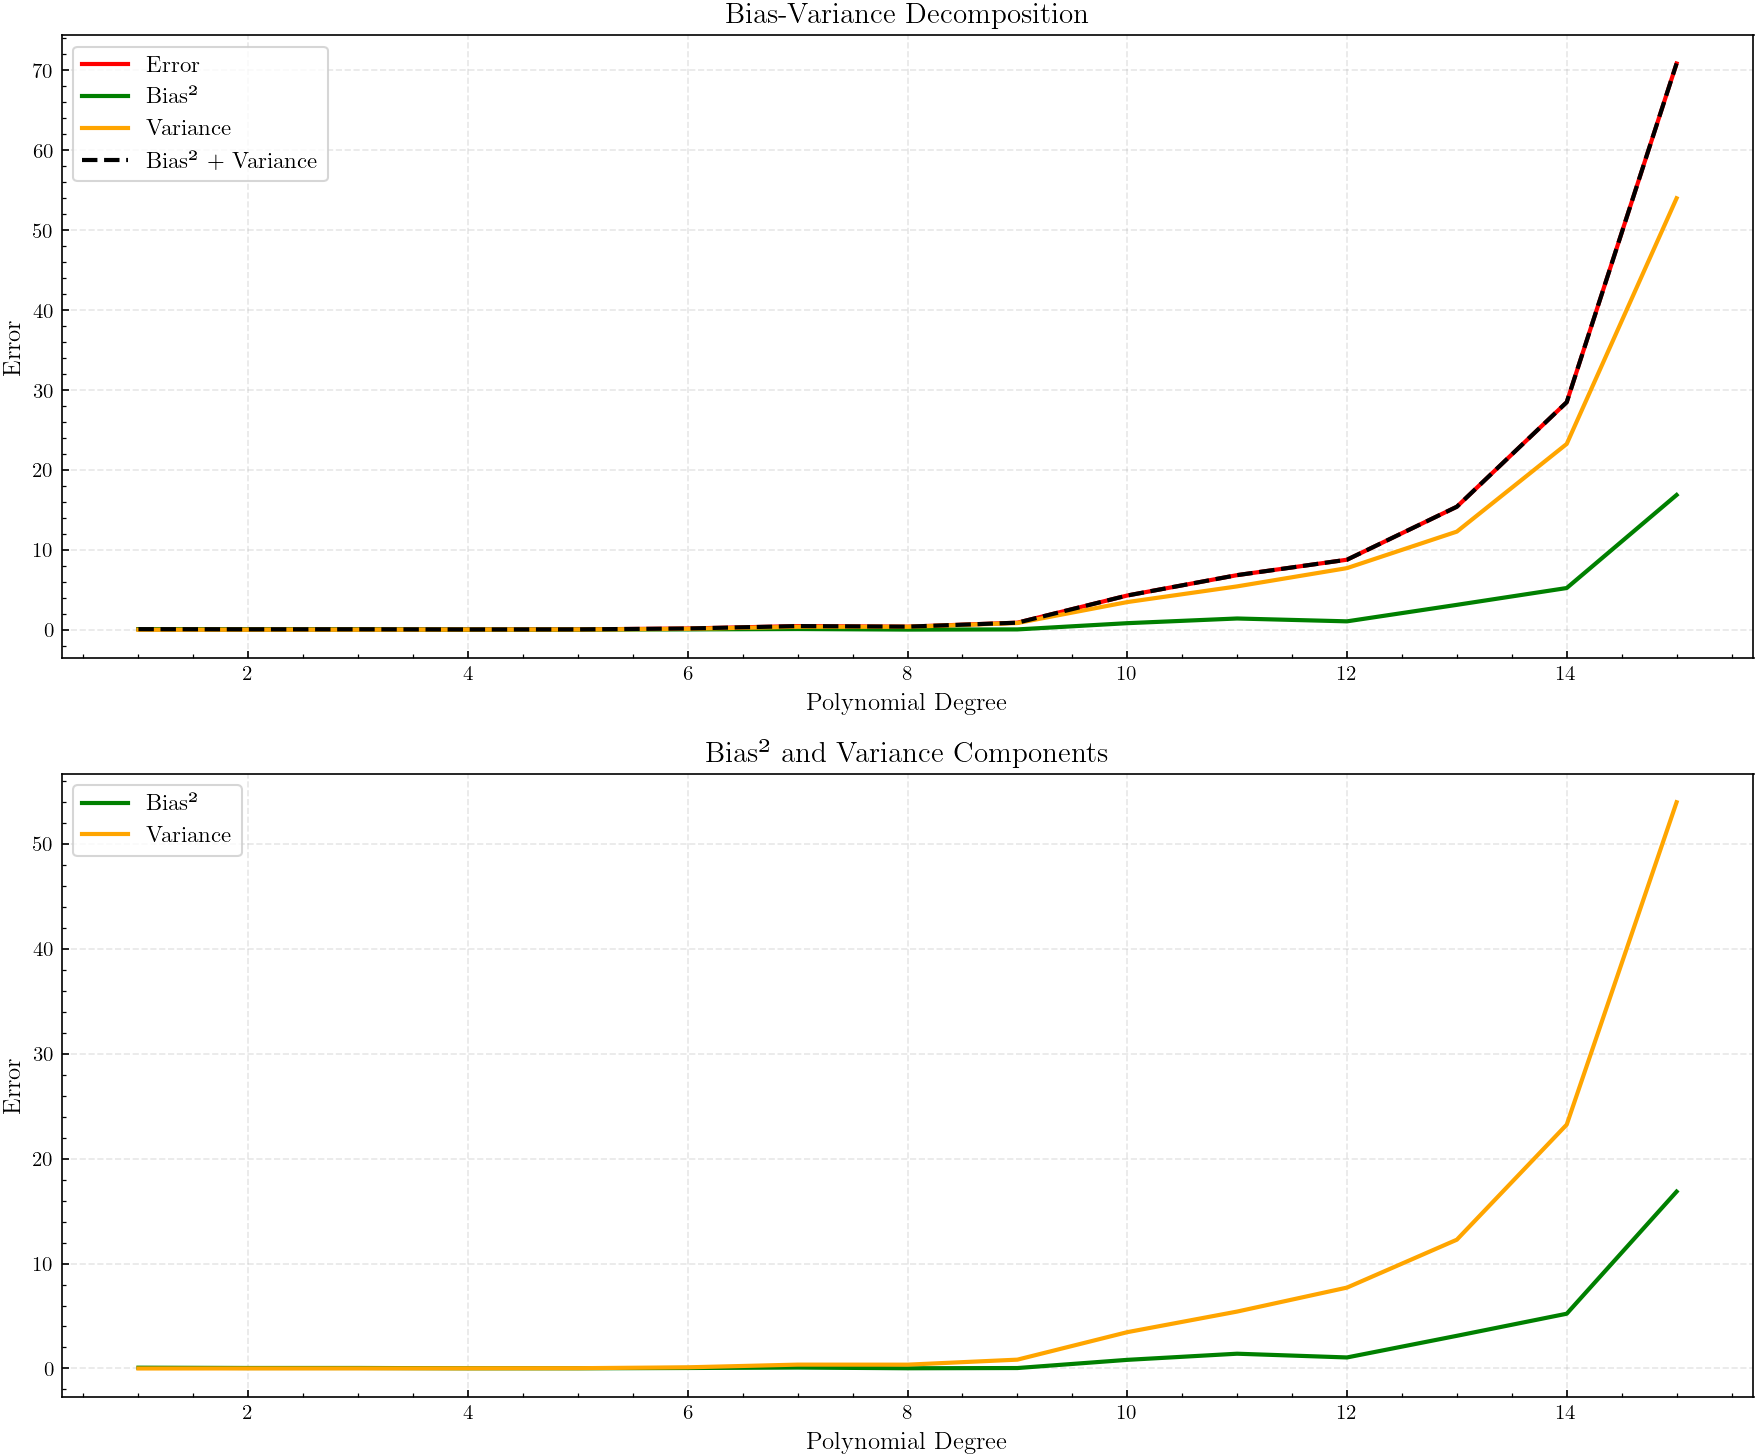


SUMMARY RESULTS
Degree   Error        Bias²        Variance     Bias²+Var   
------------------------------------------------------------
1        0.075581     0.075277     0.000304     0.075581    
2        0.052643     0.046823     0.005820     0.052643    
3        0.056540     0.047068     0.009472     0.056540    
4        0.032430     0.019426     0.013004     0.032430    
5        0.044525     0.017954     0.026571     0.044525    
6        0.156080     0.045059     0.111020     0.156080    
7        0.456317     0.089190     0.367127     0.456317    
8        0.384850     0.020775     0.364076     0.384850    
9        0.882062     0.041711     0.840352     0.882062    
10       4.279848     0.821098     3.458750     4.279848    
11       6.828334     1.406969     5.421365     6.828334    
12       8.755655     1.050328     7.705327     8.755655    
13       15.382201    3.112449     12.269752    15.382201   
14       28.450758    5.216636     23.234122    28.450758   
15     

In [100]:
# Plot bias-variance decomposition
plt.figure(figsize=(12, 8))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Error, Bias, and Variance
ax1.plot(degrees, error, 'r-', label='Error', linewidth=2)
ax1.plot(degrees, bias, 'g-', label='Bias²', linewidth=2)
ax1.plot(degrees, variance, 'orange', label='Variance', linewidth=2)
ax1.plot(degrees, bias + variance, 'k--', label='Bias² + Variance', linewidth=2)
ax1.set_xlabel('Polynomial Degree', fontsize=12)
ax1.set_ylabel('Error', fontsize=12)
ax1.set_title('Bias-Variance Decomposition', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
# ax1.set_yscale('log')

# Bottom plot: Individual components
ax2.plot(degrees, bias, 'g-', label='Bias²', linewidth=2)
ax2.plot(degrees, variance, 'orange', label='Variance', linewidth=2)
ax2.set_xlabel('Polynomial Degree', fontsize=12)
ax2.set_ylabel('Error', fontsize=12)
ax2.set_title('Bias² and Variance Components', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
# ax2.set_yscale('log')

plt.tight_layout()
plt.savefig("Plots/bias_variance_decomposition_bootstrap.pdf", bbox_inches="tight")
plt.show()

# Print summary results
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
print(f"{'Degree':<8} {'Error':<12} {'Bias²':<12} {'Variance':<12} {'Bias²+Var':<12}")
print("-"*60)

for i, degree in enumerate(degrees):
    print(f"{degree:<8} {error[i]:<12.6f} {bias[i]:<12.6f} {variance[i]:<12.6f} {bias[i]+variance[i]:<12.6f}")

print(f"\nKey findings:")
print(f"• Minimum error occurs at degree {np.argmin(error)+1}")
print(f"• Minimum bias² occurs at degree {np.argmin(bias)+1}")
print(f"• Maximum variance occurs at degree {np.argmax(variance)+1}")
print(f"• The bias-variance trade-off is clearly visible")


In [101]:
# (5) Analysis of different sample sizes
print("\n" + "="*60)
print("ANALYSIS OF DIFFERENT SAMPLE SIZES")
print("="*60)

# Test with different sample sizes
sample_sizes = [50, 100, 200]
degree_for_analysis = 8  # Fixed degree for comparison

for n_samples in sample_sizes:
    print(f"\nAnalyzing with {n_samples} samples...")
    
    # Generate new data
    x_temp, y_temp, x_train_temp, x_test_temp, y_train_temp, y_test_temp, y_noisy_temp = prepare_data(n=n_samples)
    
    # Create polynomial features
    X_train_poly = polynomial_features(x_train_temp, degree_for_analysis, intercept=False)
    X_test_poly = polynomial_features(x_test_temp, degree_for_analysis, intercept=False)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)
    
    # Bootstrap resampling
    y_pred = np.empty((len(y_test_temp), n_bootstrap))
    y_offset = np.mean(y_train_temp)
    
    for i in range(n_bootstrap):
        X_boot, y_boot = resample(X_train_scaled, y_train_temp)
        beta = OLS_parameters(X_boot, y_boot)
        y_pred[:, i] = X_test_scaled @ beta + y_offset
    
    # Calculate bias and variance - FIXED VERSION
    y_test_reshaped = y_test_temp.reshape(-1, 1)
    error_temp = np.mean(np.mean((y_test_reshaped - y_pred)**2, axis=1, keepdims=True))
    mean_prediction = np.mean(y_pred, axis=1, keepdims=True)
    bias_temp = np.mean((y_test_reshaped - mean_prediction)**2)
    variance_temp = np.mean(np.var(y_pred, axis=1, keepdims=True))
    
    print(f"  Sample size: {n_samples}")
    print(f"  Error: {error_temp:.6f}")
    print(f"  Bias²: {bias_temp:.6f}")
    print(f"  Variance: {variance_temp:.6f}")
    print(f"  Bias² + Variance: {bias_temp + variance_temp:.6f}")

print("\n" + "="*60)
print("DISCUSSION OF BIAS-VARIANCE TRADE-OFF")
print("="*60)
print("1. Model Complexity vs Performance:")
print("   - Low degree polynomials: High bias, low variance (underfitting)")
print("   - High degree polynomials: Low bias, high variance (overfitting)")
print("   - Optimal degree balances bias and variance")
print("\n2. Effect of Sample Size:")
print("   - More data generally reduces variance")
print("   - Bias is less affected by sample size")
print("   - Larger datasets allow for more complex models")
print("\n3. Bootstrap Resampling:")
print("   - Provides robust estimates of bias and variance")
print("   - Shows how model performance varies with different training sets")
print("   - Validates the theoretical bias-variance decomposition")



ANALYSIS OF DIFFERENT SAMPLE SIZES

Analyzing with 50 samples...
  Sample size: 50
  Error: 1.907744
  Bias²: 0.117932
  Variance: 1.789812
  Bias² + Variance: 1.907744

Analyzing with 100 samples...
  Sample size: 100
  Error: 0.379274
  Bias²: 0.017680
  Variance: 0.361594
  Bias² + Variance: 0.379274

Analyzing with 200 samples...
  Sample size: 200
  Error: 0.015209
  Bias²: 0.005727
  Variance: 0.009481
  Bias² + Variance: 0.015209

DISCUSSION OF BIAS-VARIANCE TRADE-OFF
1. Model Complexity vs Performance:
   - Low degree polynomials: High bias, low variance (underfitting)
   - High degree polynomials: Low bias, high variance (overfitting)
   - Optimal degree balances bias and variance

2. Effect of Sample Size:
   - More data generally reduces variance
   - Bias is less affected by sample size
   - Larger datasets allow for more complex models

3. Bootstrap Resampling:
   - Provides robust estimates of bias and variance
   - Shows how model performance varies with different train

Plot from weekly exercises BiasVarTradeoff

In [133]:
np.random.seed(6114)
rng = np.random.default_rng(6114)

x, y, x_train, x_test, y_train, y_test, y_noisy = prepare_data(n=200)
y_train = y_train + rng.normal(0, 0.1, size=len(y_train))


bootstraps = 2000
degree = 18

biases = []
variances = []
mses = []


for p in range(1, degree + 1):
    X_train = polynomial_features(x_train, p, intercept=False)  # let OLS learn intercept
    X_test  = polynomial_features(x_test,  p, intercept=False)

    predictions = np.empty((bootstraps, len(y_test)))

    for b in range(bootstraps):
        Xb, yb = resample(X_train, y_train)

        scaler = StandardScaler().fit(Xb)  # centers columns incl. intercept; intercept will be shifted—see note below
        Xb_s   = scaler.transform(Xb)
        Xte_s  = scaler.transform(X_test)
        
        y_mean = np.mean(yb)
        beta = OLS_parameters(Xb_s, yb)    # returns coefficients incl. intercept term
        predictions[b, :] = Xte_s @ beta + y_mean

    mean_pred = predictions.mean(axis=0)

    mse = ((predictions - y_test)**2).mean()
    bias_est  = ((y_test - mean_pred)**2).mean()  # inflated if y_test has noise
    variance = ((predictions**2).mean(axis=0) - mean_pred**2).mean()

    biases.append(bias_est)
    variances.append(variance)
    mses.append(mse)


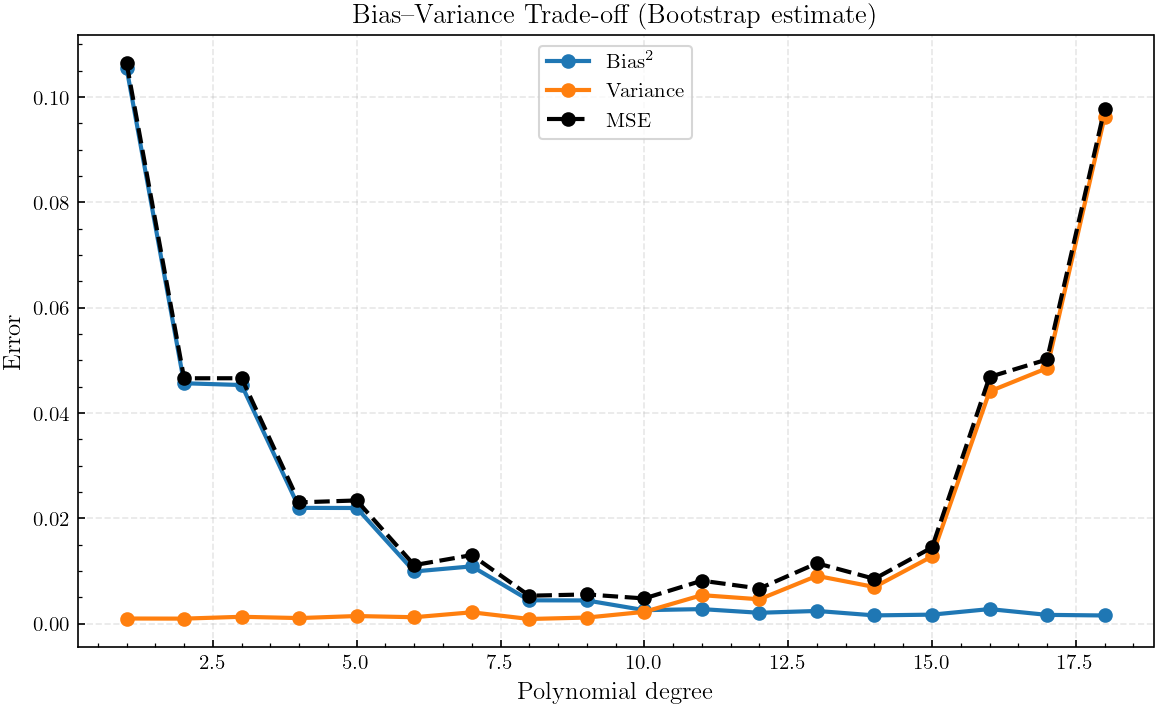

In [135]:
degrees = np.arange(1, degree+1)

plt.figure(figsize=(8, 5))

plt.plot(degrees, biases, marker="o", label=r"Bias$^2$", linewidth=2)
plt.plot(degrees, variances, marker="o", label="Variance", linewidth=2)
plt.plot(degrees, mses, marker="o", label="MSE", linewidth=2, linestyle="--", color="black")

plt.xlabel("Polynomial degree", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.title("Bias–Variance Trade-off (Bootstrap estimate)", fontsize=13)
plt.legend(frameon=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Plots/bias_variance_tradeoff.pdf", bbox_inches="tight")
plt.show()
